# start

from 0322_6; oversample pos cases

In [1]:
PRFX='0322_7'
trntmstmp=1584412344
valtmstmp=1584979040
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])


['2020-03-17 02:32:24', '2020-03-23 15:57:20']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']


# setup

In [110]:
from pathlib import Path
# import dask
# print('dask.__version__', dask.__version__)
import xgboost as xgb
# import dask_xgboost
# import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
from collections import Counter
pd.set_option('display.max_rows', 500)

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 

def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = \
    ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    ((
        (1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)
     ) +
     (
        data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)
     )))

    return calibrated_data



cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

tgt2col=dict(zip(tgts,cols_tgt))
tgt2col

{'Retweet': 'retwt',
 'Reply': 'reply',
 'Like': 'like',
 'RTwCmnt': 'retwt_cmmnt'}

# prepare data

## get maps from dfval

In [3]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

## prep func

In [4]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    
    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm
        
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])        
    return df

In [5]:
grand_total, grand_total/1e6

(150000000.0, 150.0)

## valid data

In [152]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6)
# first chunk as validate data
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') 
           for o in (df.tm.min(), df.tm.max())])
    dfvalid = prp_df(df)
    break
dfvalid.shape

cols_feat=[o for o in dfvalid.columns if o not in cols_tgt]

# Xvl,yvl=dfvl[cols_feat],dfvl[cols_tgt]

2020-03-23 02:48:00 chunk 0
['2020-02-06 00:00:00', '2020-02-12 23:59:59']


## trnval data func

In [2]:
tgt=tgts[1]
tgtcol=tgt2col[tgt]

chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e4)
len_df_wanted = int(1e4)
# retwt          0.113031
# reply          0.027488
# like           0.439499
# retwt_cmmnt    0.007742
pos_rate_wanted = 0.1
n_pos_wanted = int(len_df_wanted*pos_rate_wanted)
print('n_pos_wanted', n_pos_wanted)
np.random.seed(SEED)
lst_df = []
n_pos_ttl = 0
for ichnk,df in enumerate(chnks_trn):
    #skip first chunk (it was validate data)
    if ichnk==0: continue
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)
    n_pos_ttl+= df[tgtcol].sum()
    lst_df.append(df)
    if n_pos_ttl>=n_pos_wanted: break

df = pd.concat(lst_df)
df.reset_index(drop=True,inplace=True)


# https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset
idx_neg=np.where(df[tgtcol]==0)[0]
n_neg = len(idx_neg)
n_pos = len(df)-len(idx_neg)
n_neg2keep = len_df_wanted-n_pos
n_neg2rmv = n_neg-n_neg2keep
idx_neg2rmv = np.random.choice(idx_neg, n_neg2rmv, replace=False)
dftrvl = df.drop(idx_neg2rmv)
print('dftrvl.shape:',dftrvl.shape,'dftrvl[tgtcol].mean():',dftrvl[tgtcol].mean())

pops={
    'train_pop':len(df),
    'target_pop':n_pos,
    'sampled_train_pop':len_df_wanted,
    'sampled_target_pop':n_pos,
}
print(pops)

NameError: name 'tgts' is not defined

In [154]:
dftrvl.head()

,u1_fllwer_cnt,u1_fllwng_cnt,u1_vrfed,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u1_fllw_u2,len_toks,has_media_Photo,has_media_Video,...,lang_F73266A79468BB89C4325FDEDB0B533C,lang_4690215948DBF6872B8ED1C2BC87B17E,lang_D18801336202297E6484F634CAC6592E,lang_2E18F6F53E3CF073911AF0A93BBE5373,lang_B2235C8B73239FDC5780DD132419833A,lang_515E873C86EE1577E75FA2387B7FA59E,retwt,reply,like,retwt_cmmnt
6,69943477,60576,True,79,127,False,False,19,False,False,...,0,0,0,0,0,0,0,0,1,0
10,300595,822,True,101,914,False,False,301,True,False,...,0,0,0,0,0,0,0,0,1,0
20,809,499,False,1556,810,False,True,131,True,False,...,0,0,0,0,0,0,0,1,1,0
22,162028,257,False,138,360,False,False,49,False,False,...,0,0,0,0,0,0,1,1,1,0
23,3226988,1,True,0,195,False,False,416,True,False,...,0,0,0,0,0,0,0,0,0,0


In [100]:
# df.columns

In [114]:
dftrvl = df.sample(len(dftrvl))

In [123]:
# tgt2ytr={tgt:ytr.iloc[:,i] for i,tgt in enumerate(tgts)}
# tgt2yvl={tgt:yvl.iloc[:,i] for i,tgt in enumerate(tgts)}

In [1]:
def getdftrvl(tgt):
    print(tgt)
    tgtcol=tgt2col[tgt]
    chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                        header=None,names=cols, 
                            chunksize=1e4)
    len_df_wanted = int(1e4)
    # retwt          0.113031
    # reply          0.027488
    # like           0.439499
    # retwt_cmmnt    0.007742
    pos_rate_wanted = 0.1
    n_pos_wanted = int(len_df_wanted*pos_rate_wanted)
    print('n_pos_wanted', n_pos_wanted)
    np.random.seed(SEED)
    lst_df = []
    n_pos_ttl = 0
    for ichnk,df in enumerate(chnks_trn):
        #skip first chunk (it was validate data)
        if ichnk==0: continue
        print(dtnow(), 'chunk', ichnk)
        df = prp_df(df)
        n_pos_ttl+= df[tgtcol].sum()
        lst_df.append(df)
        if n_pos_ttl>=n_pos_wanted: break

    df = pd.concat(lst_df)
    df.reset_index(drop=True,inplace=True)


    # https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset
    idx_neg=np.where(df[tgtcol]==0)[0]
    n_neg = len(idx_neg)
    n_pos = len(df)-len(idx_neg)
    n_neg2keep = len_df_wanted-n_pos
    n_neg2rmv = n_neg-n_neg2keep
    idx_neg2rmv = np.random.choice(idx_neg, n_neg2rmv, replace=False)
    dftrvl = df.drop(idx_neg2rmv)
    dftrvl = df.sample(len(dftrvl))
    print('dftrvl.shape:',dftrvl.shape,'dftrvl[tgtcol].mean():',dftrvl[tgtcol].mean())
    print('dftr.shape:',dftr.shape,'dftr[tgtcol].mean():',dftr[tgtcol].mean())

    pops={
        'train_pop':len(df),
        'target_pop':n_pos,
        'sampled_train_pop':len_df_wanted,
        'sampled_target_pop':n_pos,
    }
    print(pops)
    return dftr, pops

# model

In [150]:

def train(params,dtr,dvl):
    print(params)
    evals_result = {}
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=100,#1000, 
                    evals=evallist, evals_result=evals_result, 
                    verbose_eval=50,
                    early_stopping_rounds=50)
    return bst,evals_result

def valid(bst,dtr,dvl):
    prdtr = bst.predict(dtr, ntree_limit=bst.best_ntree_limit)
    prdvl = bst.predict(dvl, ntree_limit=bst.best_ntree_limit)
    return prdtr,prdvl

def do_tgt(tgt):
    params=tgt2params[tgt]
    tgtcol=tgt2col[tgt]
    dtr = xgb.DMatrix(dftr[cols_feat], label=dftr[tgtcol], feature_names=cols_feat)
    dvl = xgb.DMatrix(dfvl[cols_feat], label=dfvl[tgtcol], feature_names=cols_feat)
    bst,evals_result=train(params,dtr,dvl)
    prdtr,prdvl=valid(bst,dtr,dvl)
    tgt2bst[tgt]=bst
    tgt2evalres[tgt]=evals_result
    tgt2ytr[tgt]=dftr[tgtcol]
    tgt2yvl[tgt]=dfvl[tgtcol]
    tgt2prdtr[tgt]=prdtr
    tgt2prdvl[tgt]=prdvl

In [151]:
tgt2params = {k:{'objective': 'binary:logistic',
    'verbosity': 1,
    'eval_metric': ['logloss', 'aucpr',],
} for k in tgts}

tgt2bst={}
tgt2evalres={}
tgt2ytr={}
tgt2yvl={}
tgt2prdtr={}
tgt2prdvl={}
for tgt in tgts:
    print(dtnow(), tgt)
    do_tgt(tgt)
    
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-23 02:46:26 Retweet
{'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['logloss', 'aucpr']}
[0]	train-logloss:0.58123	train-aucpr:0.39137	eval-logloss:0.56015	eval-aucpr:0.20673
Multiple eval metrics have been passed: 'eval-aucpr' will be used for early stopping.

Will train until eval-aucpr hasn't improved in 50 rounds.
[50]	train-logloss:0.28752	train-aucpr:0.85477	eval-logloss:0.35714	eval-aucpr:0.22776
Stopping. Best iteration:
[18]	train-logloss:0.36701	train-aucpr:0.65300	eval-logloss:0.35192	eval-aucpr:0.23621

2020-03-23 02:46:47 Reply
{'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['logloss', 'aucpr']}
[0]	train-logloss:0.46766	train-aucpr:0.18002	eval-logloss:0.46696	eval-aucpr:0.05918
Multiple eval metrics have been passed: 'eval-aucpr' will be used for early stopping.

Will train until eval-aucpr hasn't improved in 50 rounds.
[50]	train-logloss:0.04426	train-aucpr:0.98504	eval-logloss:0.12623	eval-aucpr:0.06857
Stopping. Best iteration

## analyze

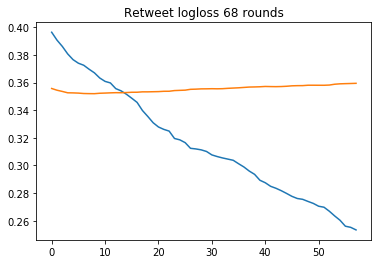

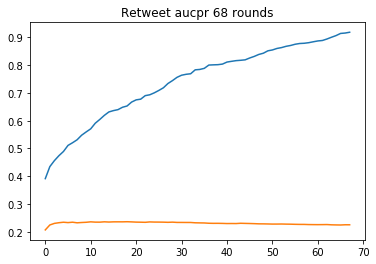

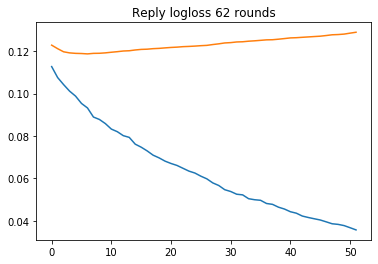

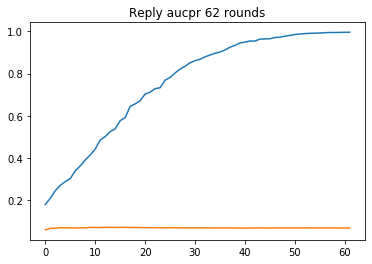

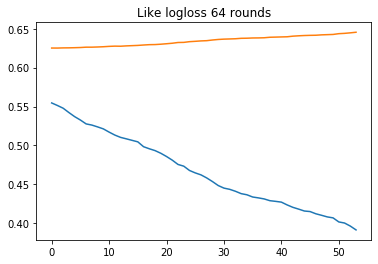

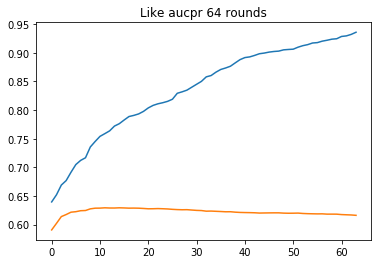

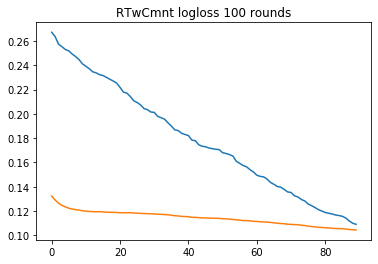

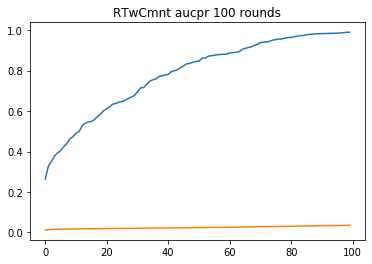

In [148]:
for tgt in tgt2evalres:
    evalres=tgt2evalres[tgt]
    plt.plot(evalres['train']['logloss'][10:])
    plt.plot(evalres['eval']['logloss'][10:])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()

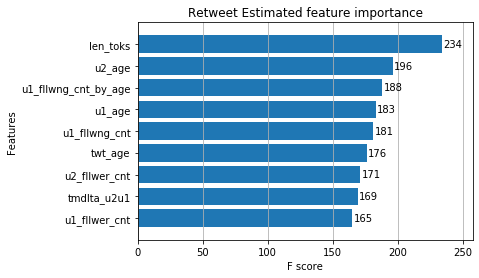

Retweet


,0,1
16,len_toks,234
4,u2_age,196
20,u1_fllwng_cnt_by_age,188
10,u1_age,183
17,u1_fllwng_cnt,181
18,twt_age,176
1,u2_fllwer_cnt,171
6,tmdlta_u2u1,169
11,u1_fllwer_cnt,165
5,u1_fllwer_cnt_by_age,153


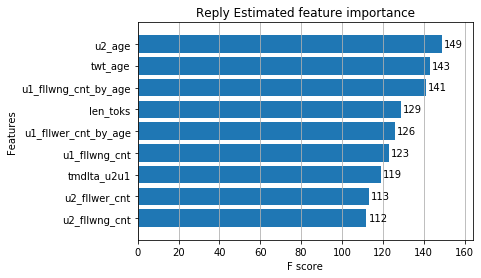

Reply


,0,1
2,u2_age,149
8,twt_age,143
4,u1_fllwng_cnt_by_age,141
17,len_toks,129
1,u1_fllwer_cnt_by_age,126
18,u1_fllwng_cnt,123
7,tmdlta_u2u1,119
6,u2_fllwer_cnt,113
12,u2_fllwng_cnt,112
10,u1_age,107


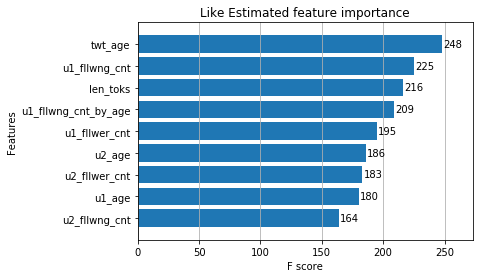

Like


,0,1
8,twt_age,248
4,u1_fllwng_cnt,225
3,len_toks,216
2,u1_fllwng_cnt_by_age,209
7,u1_fllwer_cnt,195
13,u2_age,186
9,u2_fllwer_cnt,183
5,u1_age,180
16,u2_fllwng_cnt,164
18,u1_fllwer_cnt_by_age,151


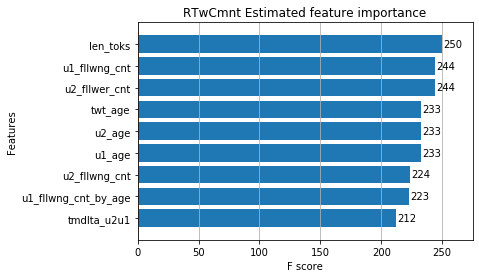

RTwCmnt


,0,1
6,len_toks,250
0,u2_fllwer_cnt,244
4,u1_fllwng_cnt,244
5,u1_age,233
8,u2_age,233
13,twt_age,233
7,u2_fllwng_cnt,224
11,u1_fllwng_cnt_by_age,223
1,u1_fllwer_cnt,212
12,tmdlta_u2u1,212


In [149]:
def show_feat_importance(tgt):
    bst=tgt2bst[tgt]
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    print(tgt)
    display(pd.DataFrame([feat2importance.keys(), 
                          feat2importance.values()]).T.sort_values(1, ascending=False))

for tgt in tgt2bst:
    show_feat_importance(tgt)

In [140]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for tgt in tgt2bst:
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train prauc:', f'{scr_auc_trn:.4f}','train rce:', f'{scr_rce_trn:.4f}', )
    print('valid prauc:', f'{scr_auc_val:.4f}','valid rce:', f'{scr_rce_val:.4f}', )

Retweet


NameError: name 'tgt2ytr' is not defined

In [159]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    if tgt not in tgt2bst: continue
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.418703,16.418,0.120596,12.3247,0.750463,20.3474,0.151107,10.5843
scrval,0.341082,11.3916,0.0941483,10.0383,0.700746,15.4905,0.0913106,6.46117


# infer

In [39]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 28s, sys: 12.6 s, total: 1min 41s
Wall time: 2min 34s


In [40]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 1min 42s, sys: 13.9 s, total: 1min 56s
Wall time: 2min 6s


In [41]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtst[tgt] = bst.predict(dtst)

2020-03-22 16:15:47 Retweet
2020-03-22 16:16:25 Reply
2020-03-22 16:16:41 Like
2020-03-22 16:18:54 RTwCmnt
CPU times: user 24min 3s, sys: 31 s, total: 24min 34s
Wall time: 5min 16s


In [42]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [45]:
%%time
for i,tgt in enumerate(['Retweet','Reply','RTwCmnt','Like',]):
    dfsub = tgt2dfsub[tgt]
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{i}_{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-22 16:32:10 Retweet
2020-03-22 16:34:07 Reply
2020-03-22 16:36:02 RTwCmnt
2020-03-22 16:37:55 Like
CPU times: user 6min 27s, sys: 7.74 s, total: 6min 34s
Wall time: 7min 37s
